In [1]:
import importlib
import models
importlib.reload(models)

<module 'models' from 'c:\\Users\\louis\\Desktop\\indicator-forecasting\\models.py'>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
from tqdm import tqdm
from dataset import get_dataloader, plot_statistical_analysis
from torch.utils.data import Subset
import random
from models import load_model_squeezenet, load_model_resnet_18
from performance import plot_full_evaluation_dashboard
from inference import inference, inference_df
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch
from typing import Callable
import sys
from typing import Type

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

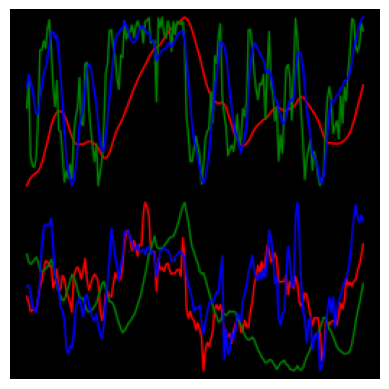

In [24]:
img = mpimg.imread('data\\BIIB_0.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [17]:
TRAIN_DIR = "data_synth/"
TEST_DIR = "test_synth/"
SYNTH_DIR = 'synth/'

LABELS_DIR = "labels"
TRAIN_LABEL_FILE = "train_synth_labels.json"
TEST_LABEL_FILE = "test_synth_labels.json"
SYNTH_LABEL_FILE = "synth_labels.json"
TRAIN_LABEL_PATH = os.path.join(LABELS_DIR, TRAIN_LABEL_FILE)
TEST_LABEL_PATH = os.path.join(LABELS_DIR, TEST_LABEL_FILE)
SYNTH_LABEL_PATH = os.path.join(LABELS_DIR, SYNTH_LABEL_FILE)

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_DIR = 'model'
MODEL_NAME = 'squeeze_multilabel2'
MODEL_FILE = MODEL_NAME + '.pth'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILE)

PERF_DIR = 'performances'
PERF_FILE = MODEL_NAME + '.png'
PERF_PATH = os.path.join(PERF_DIR, PERF_FILE)

LOSS_FILE = MODEL_NAME + '_loss.png'
LOSS_PATH = os.path.join(PERF_DIR, LOSS_FILE)

INDICS = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']


IMAGE_SIZE = 128

In [9]:
train_loader, train_dataset = get_dataloader(TRAIN_DIR, TRAIN_LABEL_PATH, TRAIN_BATCH_SIZE, img_size= IMAGE_SIZE)

test_loader, test_dataset = get_dataloader(TEST_DIR, TEST_LABEL_PATH, TEST_BATCH_SIZE, shuffle = False, img_size= IMAGE_SIZE)

test_synth_loader, test_synth_dataset = get_dataloader(SYNTH_DIR, SYNTH_LABEL_PATH, TEST_BATCH_SIZE, shuffle = False, img_size= IMAGE_SIZE)

# Create a smaller test subset
subset_size = 1000
assert subset_size <= len(test_dataset), "Subset size exceeds size of test dataset"

# Random sample without replacement
random.seed(42)
indices = random.sample(range(len(test_dataset)), subset_size)

# Wrap in Subset and new DataLoader
small_test_dataset = Subset(test_dataset, indices)
small_test_loader = DataLoader(small_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


indices = random.sample(range(len(test_synth_dataset)), subset_size)


# Wrap in Subset and new DataLoader
small_synth_test_dataset = Subset(test_synth_dataset, indices)
small_synth_test_loader = DataLoader(small_synth_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


📊 Train - Statistical Label Analysis


100%|██████████| 5124/5124 [01:35<00:00, 53.52it/s]


Total samples: 5124


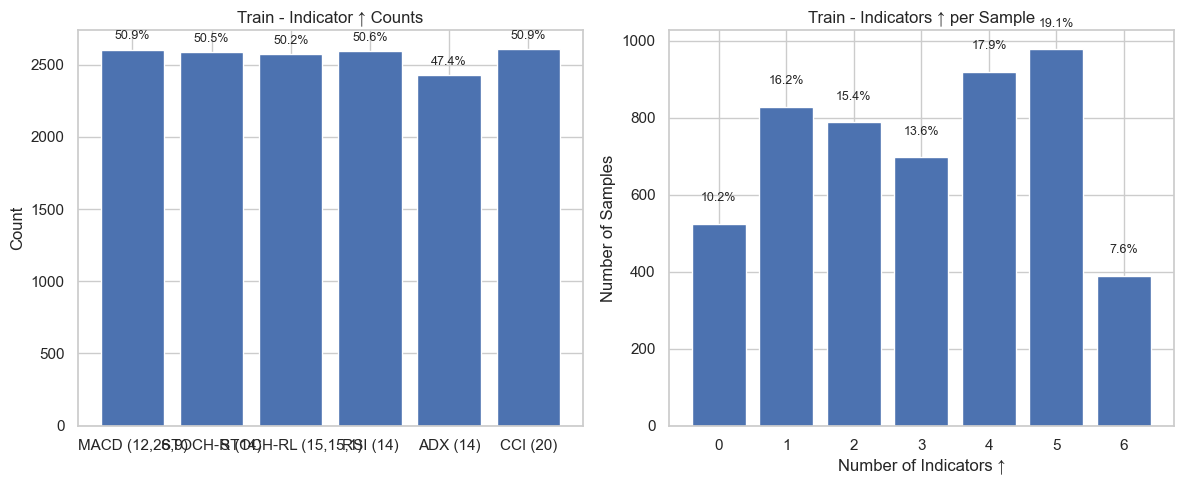

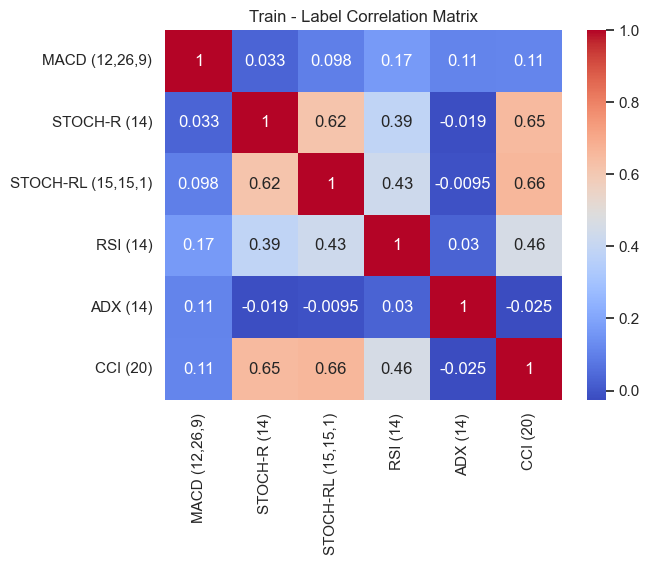


📊 Small Test - Statistical Label Analysis


100%|██████████| 2500/2500 [00:45<00:00, 54.62it/s]


Total samples: 2500


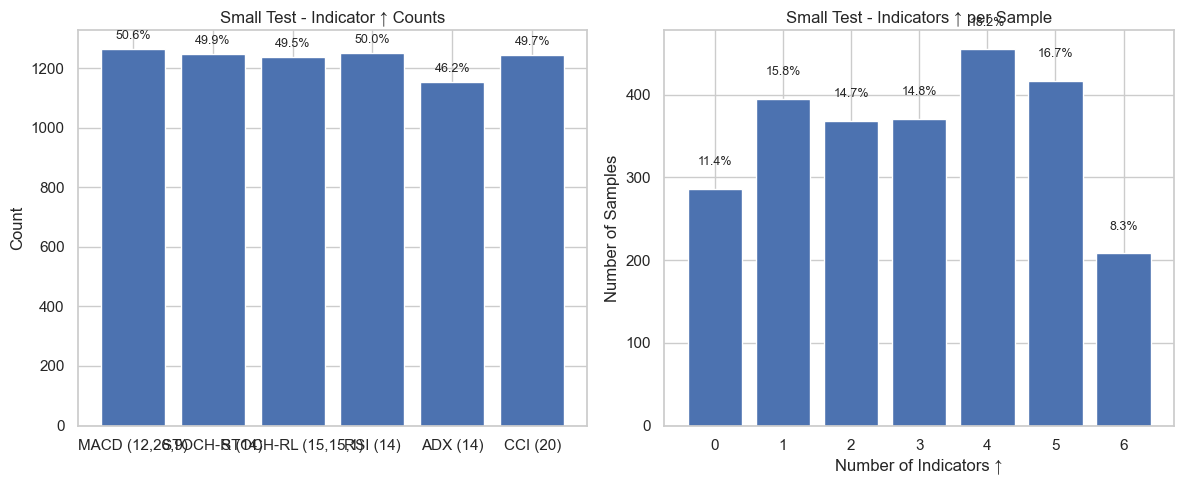

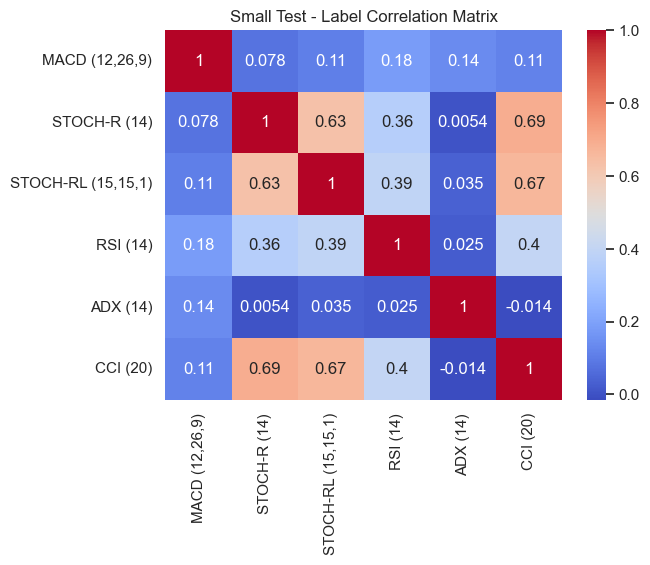


📊 Small Test Synth - Statistical Label Analysis


100%|██████████| 2500/2500 [00:42<00:00, 58.88it/s]


Total samples: 2500


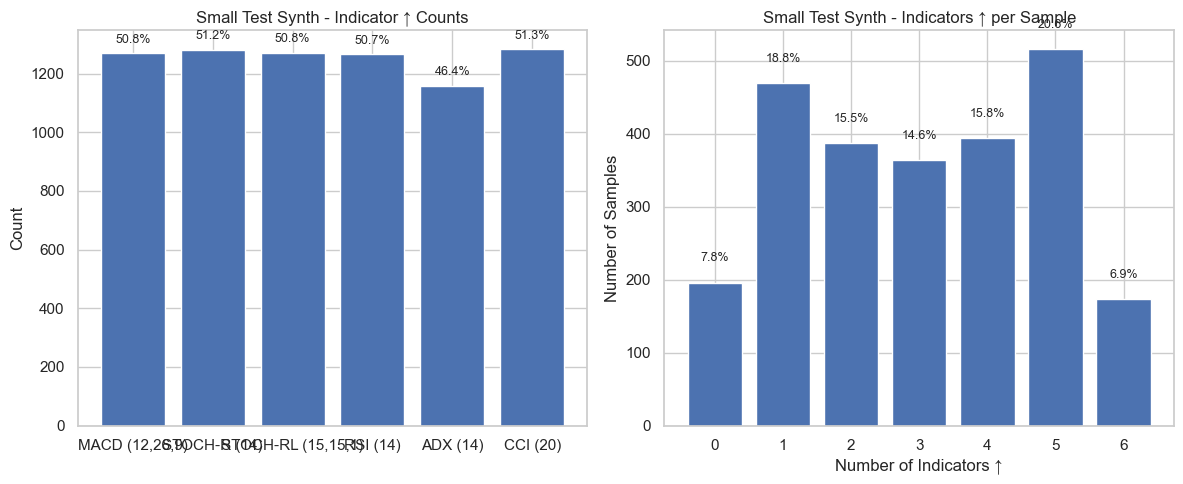

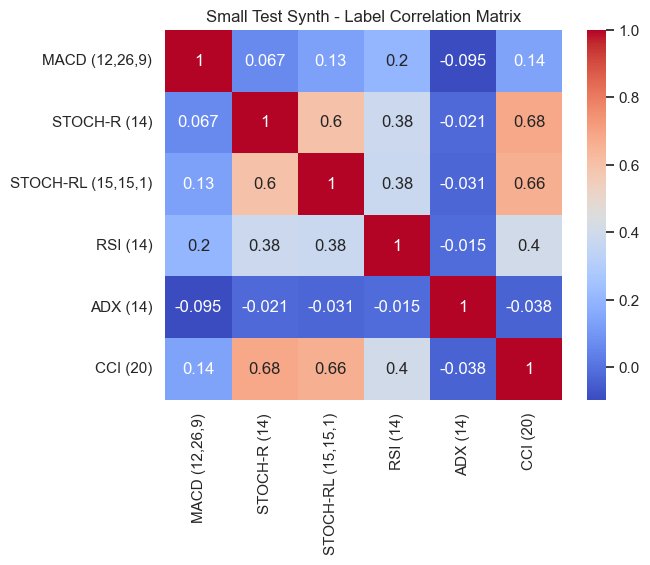

In [5]:
plot_statistical_analysis(train_dataset, INDICS, "Train")
plot_statistical_analysis(small_test_dataset, INDICS, "Small Test")
plot_statistical_analysis(small_synth_test_dataset, INDICS, "Small Test Synth")

## Perf

100%|██████████| 1000/1000 [00:24<00:00, 40.05it/s]
c:\Users\louis\Desktop\indicator-forecasting\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby("len_bin")
c:\Users\louis\Desktop\indicator-forecasting\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby("len_bin")
c:\Users\louis\Desktop\indicator-forecasting\performance.py:225: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

Saved to performances\squeeze_multilabel2.png


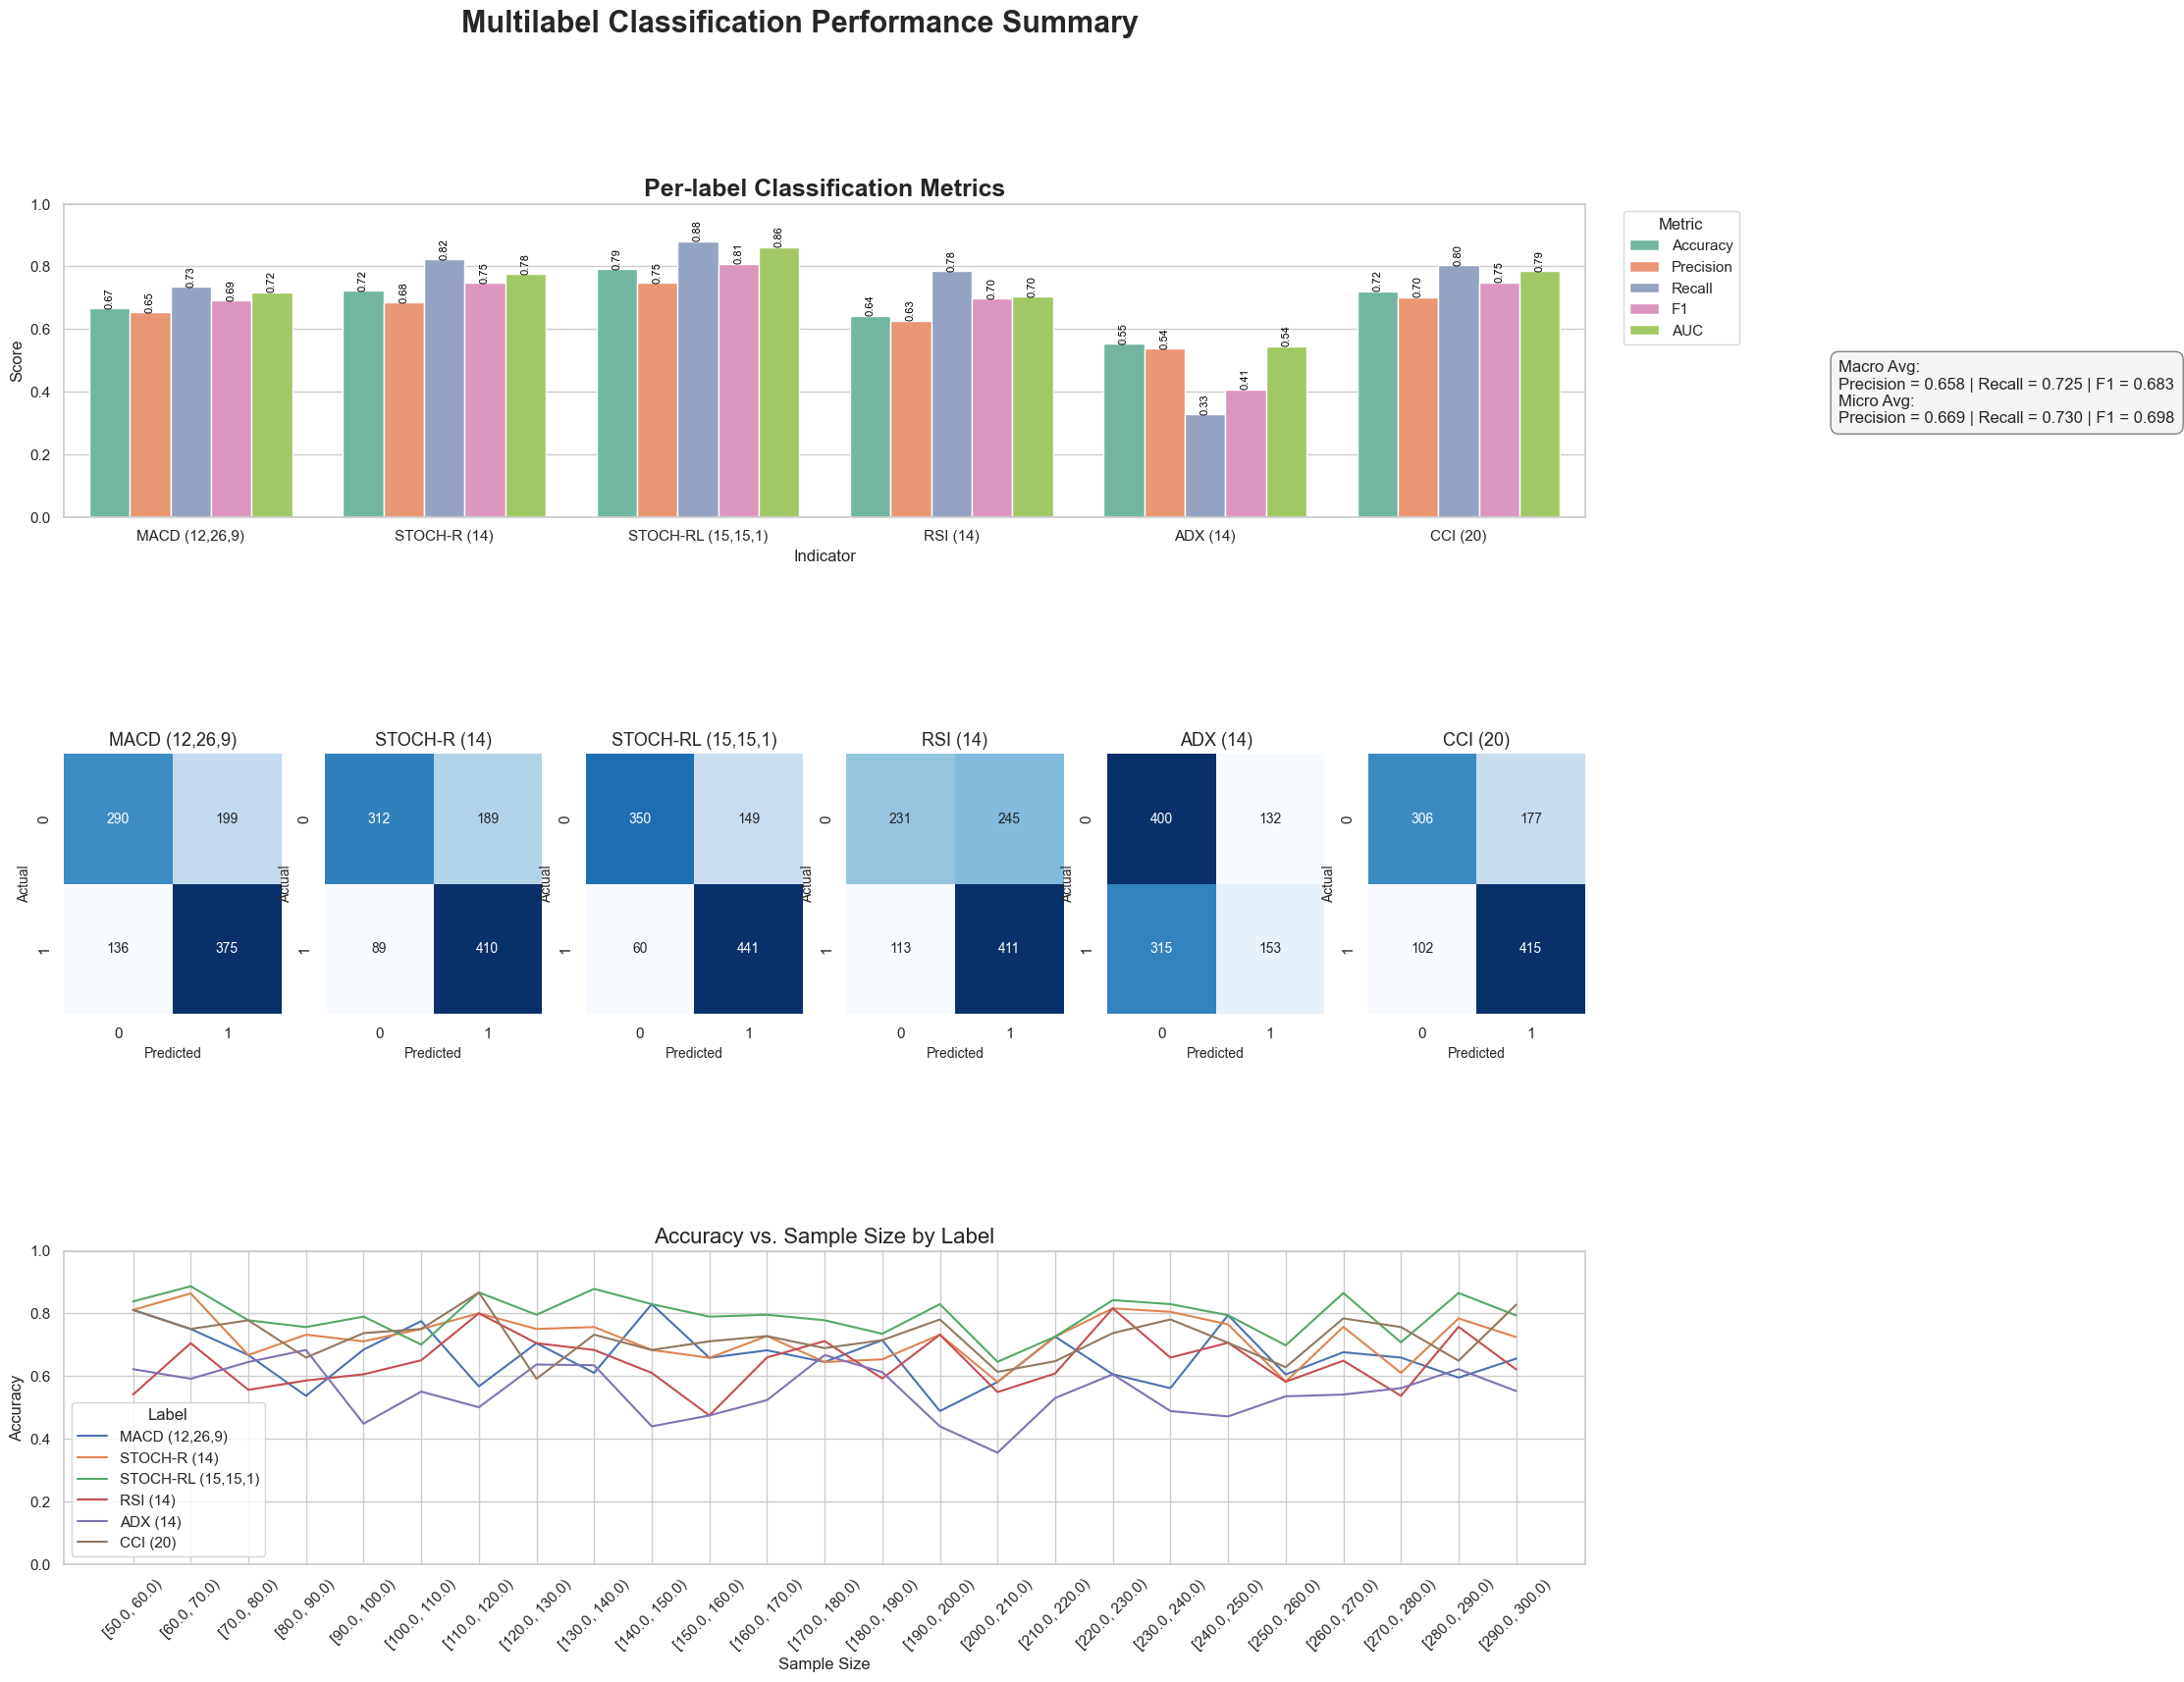

In [19]:
indics = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']


model = load_model_squeezenet(MODEL_PATH, DEVICE)
all_labels, all_preds, all_probs, _, all_lens, _ = inference (model, small_synth_test_loader, INDICS, DEVICE)

plot_full_evaluation_dashboard(all_labels, all_preds, all_probs, all_lens, indics, save_path = PERF_PATH)

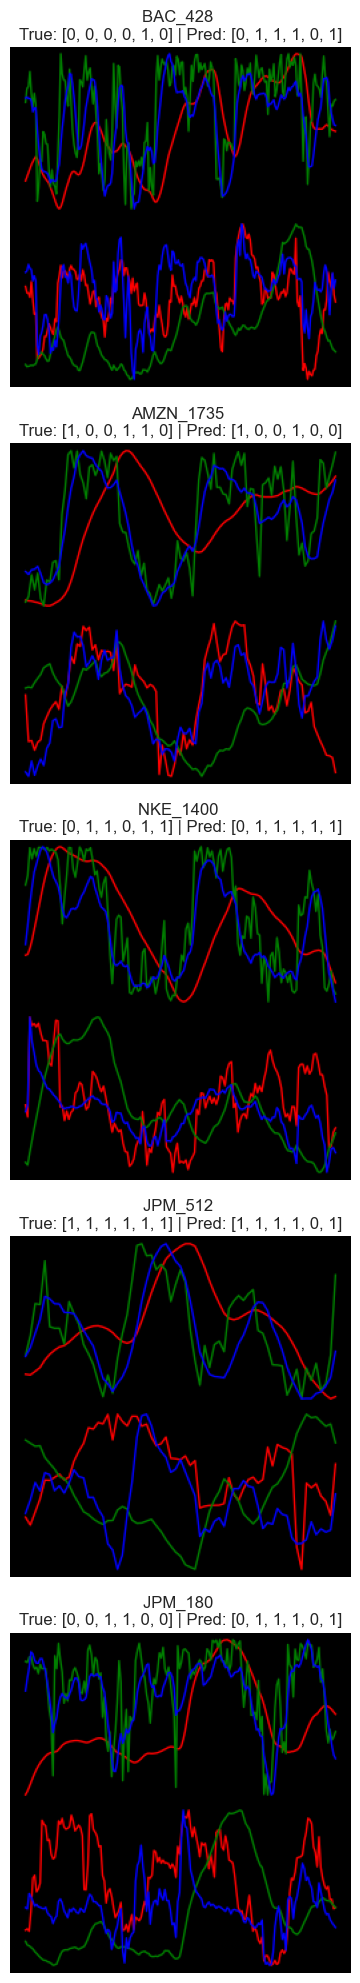

In [44]:
def show_predictions(dataset, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4 * num_samples), squeeze=False)

    for i in range(num_samples):
        img, _, _, png_file = dataset[i]
        img_disp = img.permute(1, 2, 0).numpy()  # CHW -> HWC
        img_disp = (img_disp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # denormalize
        img_disp = np.clip(img_disp, 0, 1)

        pred = y_pred[i]
        true = y_true[i]

        title = png_file.split('.')[0]
        ax = axes[i, 0]
        ax.imshow(img_disp)
        ax.axis('off')
        ax.set_title(f"{title} \nTrue: {true.tolist()} | Pred: {pred.tolist()}", fontsize=12)

    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()


# Visualize first few predictions
show_predictions(small_test_dataset, all_labels.astype(int), all_preds.astype(int), num_samples=5)


## ResNet 1

In [ ]:

EPOCHS = 4
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Load ResNet and modify last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 6),
    nn.Sigmoid()
)
model = model.to(DEVICE)

# 5. Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 6. Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels, _, _ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

# 7. Save model
torch.save(model.state_dict(), "model\\resnet_multilabel2.pth")
print("Model saved as resnet_multilabel2.pth")


## ResNet 2

c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
161it [05:25,  2.02s/it]


Epoch 1/20, Train Loss: 0.7485, Test Loss: 1864.3492
Model improved and saved.


161it [04:42,  1.75s/it]


Epoch 2/20, Train Loss: 0.7327, Test Loss: 1841.6600
Model improved and saved.


161it [03:27,  1.29s/it]


Epoch 3/20, Train Loss: 0.7187, Test Loss: 1804.7354
Model improved and saved.


161it [03:24,  1.27s/it]


Epoch 4/20, Train Loss: 0.7046, Test Loss: 1780.6556
Model improved and saved.


161it [03:24,  1.27s/it]


Epoch 5/20, Train Loss: 0.6898, Test Loss: 1752.6607
Model improved and saved.


161it [03:25,  1.28s/it]


Epoch 6/20, Train Loss: 0.6751, Test Loss: 1719.5482
Model improved and saved.


161it [03:29,  1.30s/it]


Epoch 7/20, Train Loss: 0.6606, Test Loss: 1681.9142
Model improved and saved.


161it [03:34,  1.33s/it]


Epoch 8/20, Train Loss: 0.6458, Test Loss: 1653.5332
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 9/20, Train Loss: 0.6316, Test Loss: 1621.2683
Model improved and saved.


161it [03:30,  1.30s/it]


Epoch 10/20, Train Loss: 0.6190, Test Loss: 1596.5825
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 11/20, Train Loss: 0.6083, Test Loss: 1578.1904
Model improved and saved.


161it [03:32,  1.32s/it]


Epoch 12/20, Train Loss: 0.5988, Test Loss: 1560.6595
Model improved and saved.


161it [03:33,  1.32s/it]


Epoch 13/20, Train Loss: 0.5902, Test Loss: 1540.7790
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 14/20, Train Loss: 0.5814, Test Loss: 1529.2539
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 15/20, Train Loss: 0.5751, Test Loss: 1519.9218
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 16/20, Train Loss: 0.5678, Test Loss: 1509.6003
Model improved and saved.


161it [03:31,  1.31s/it]


Epoch 17/20, Train Loss: 0.5609, Test Loss: 1505.9380
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 18/20, Train Loss: 0.5558, Test Loss: 1496.3650
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 19/20, Train Loss: 0.5503, Test Loss: 1489.8039
Model improved and saved.


161it [03:33,  1.33s/it]


Epoch 20/20, Train Loss: 0.5453, Test Loss: 1486.3238
Model improved and saved.
Model saved as resnet_multilabel2.pth


ValueError: x and y must have same first dimension, but have shapes (0,) and (20,)

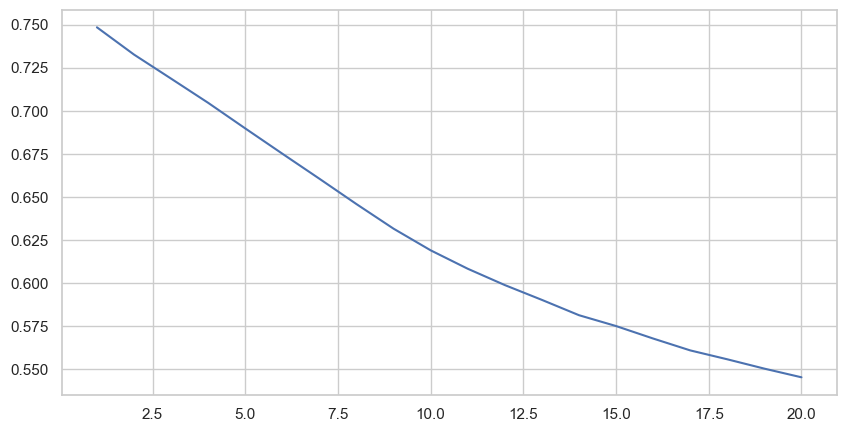

In [ ]:
EPOCHS = 20
LR = 1e-6
PATIENCE = 3  # Stop if no improvement after 2 epochs

train_losses = []
test_losses = []
epoch_train_losses =[]
epoch_test_losses =[]


# 4. Load ResNet and modify last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 6),
    nn.Sigmoid()
)
model = model.to(DEVICE)

# 5. Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    # Training
    model.train()
    running_loss = 0.0

    for i, (images, labels, *_) in tqdm(enumerate(train_loader)):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        '''if i%20 == 19 :
            train_loss = running_loss / (i*TRAIN_BATCH_SIZE)
            train_losses.append(train_loss)
            
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for images, labels, _, _ in small_test_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * images.size(0)
            test_loss = test_loss / len(small_test_loader.dataset)
            test_losses.append(test_loss)
            
            tqdm.write(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            model.train()'''

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels, *_ in small_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    epoch_test_loss = test_loss / len(small_test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model improved and saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            early_stop = True

torch.save(model.state_dict(), "resnet_multilabel2.pth")
print("Model saved as resnet_multilabel2.pth")


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig(LOSS_PATH)
plt.show()

print(f"Loss curve saved as {LOSS_PATH}")

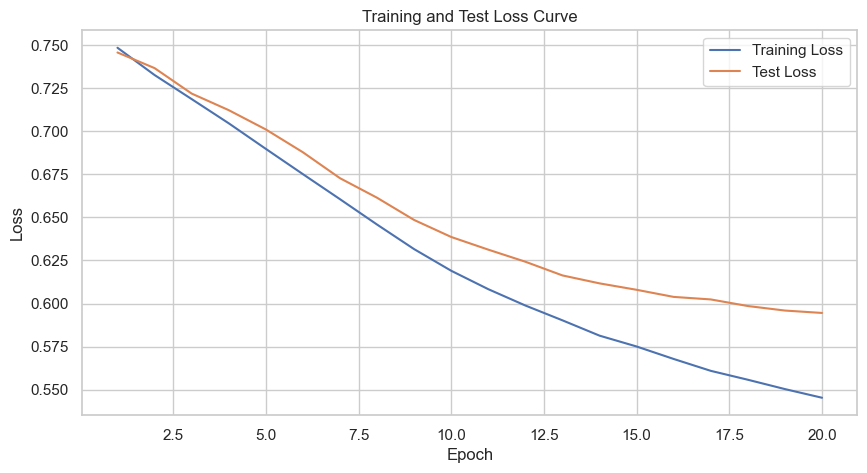

Loss curve saved as loss_curve.png


In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

print("Loss curve saved as loss_curve.png")

## SqueezeNet 1

c:\Users\louis\Desktop\indicator-forecasting\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\indicator-forecasting\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 183/183 [01:53<00:00,  1.61it/s]


Epoch 1/50, Train Loss: 0.7714, Test Loss: 0.6942
Model improved and saved.


100%|██████████| 183/183 [00:52<00:00,  3.51it/s]


Epoch 2/50, Train Loss: 0.6978, Test Loss: 0.6933
Model improved and saved.


100%|██████████| 183/183 [00:56<00:00,  3.22it/s]


Epoch 3/50, Train Loss: 0.6951, Test Loss: 0.6930
Model improved and saved.


100%|██████████| 183/183 [00:54<00:00,  3.38it/s]


Epoch 4/50, Train Loss: 0.6939, Test Loss: 0.6928
Model improved and saved.


100%|██████████| 183/183 [01:09<00:00,  2.64it/s]


Epoch 5/50, Train Loss: 0.6931, Test Loss: 0.6926
Model improved and saved.


100%|██████████| 183/183 [01:06<00:00,  2.74it/s]


Epoch 6/50, Train Loss: 0.6925, Test Loss: 0.6916
Model improved and saved.


100%|██████████| 183/183 [00:51<00:00,  3.56it/s]


Epoch 7/50, Train Loss: 0.6885, Test Loss: 0.6839
Model improved and saved.


100%|██████████| 183/183 [00:48<00:00,  3.75it/s]


Epoch 8/50, Train Loss: 0.6709, Test Loss: 0.6642
Model improved and saved.


100%|██████████| 183/183 [00:51<00:00,  3.53it/s]


Epoch 9/50, Train Loss: 0.6595, Test Loss: 0.6566
Model improved and saved.


100%|██████████| 183/183 [00:48<00:00,  3.80it/s]


Epoch 10/50, Train Loss: 0.6549, Test Loss: 0.6532
Model improved and saved.


100%|██████████| 183/183 [00:49<00:00,  3.69it/s]


Epoch 11/50, Train Loss: 0.6501, Test Loss: 0.6540


100%|██████████| 183/183 [00:49<00:00,  3.70it/s]


Epoch 12/50, Train Loss: 0.6483, Test Loss: 0.6521
Model improved and saved.


100%|██████████| 183/183 [00:47<00:00,  3.89it/s]


Epoch 13/50, Train Loss: 0.6457, Test Loss: 0.6486
Model improved and saved.


100%|██████████| 183/183 [00:50<00:00,  3.63it/s]


Epoch 14/50, Train Loss: 0.6428, Test Loss: 0.6460
Model improved and saved.


100%|██████████| 183/183 [00:51<00:00,  3.55it/s]


Epoch 15/50, Train Loss: 0.6408, Test Loss: 0.6469


100%|██████████| 183/183 [00:45<00:00,  3.98it/s]


Epoch 16/50, Train Loss: 0.6385, Test Loss: 0.6450
Model improved and saved.


100%|██████████| 183/183 [00:46<00:00,  3.90it/s]


Epoch 17/50, Train Loss: 0.6368, Test Loss: 0.6435
Model improved and saved.


100%|██████████| 183/183 [00:49<00:00,  3.67it/s]


Epoch 18/50, Train Loss: 0.6352, Test Loss: 0.6444


100%|██████████| 183/183 [00:49<00:00,  3.71it/s]


Epoch 19/50, Train Loss: 0.6329, Test Loss: 0.6423
Model improved and saved.


100%|██████████| 183/183 [01:02<00:00,  2.92it/s]


Epoch 20/50, Train Loss: 0.6310, Test Loss: 0.6435


100%|██████████| 183/183 [00:49<00:00,  3.72it/s]


Epoch 21/50, Train Loss: 0.6295, Test Loss: 0.6420
Model improved and saved.


100%|██████████| 183/183 [00:50<00:00,  3.61it/s]


Epoch 22/50, Train Loss: 0.6294, Test Loss: 0.6416
Model improved and saved.


100%|██████████| 183/183 [00:50<00:00,  3.63it/s]


Epoch 23/50, Train Loss: 0.6274, Test Loss: 0.6424


100%|██████████| 183/183 [00:57<00:00,  3.16it/s]


Epoch 24/50, Train Loss: 0.6267, Test Loss: 0.6415
Model improved and saved.


100%|██████████| 183/183 [00:51<00:00,  3.56it/s]


Epoch 25/50, Train Loss: 0.6252, Test Loss: 0.6418


100%|██████████| 183/183 [00:46<00:00,  3.92it/s]


Epoch 26/50, Train Loss: 0.6239, Test Loss: 0.6414
Model improved and saved.


100%|██████████| 183/183 [00:45<00:00,  4.02it/s]


Epoch 27/50, Train Loss: 0.6233, Test Loss: 0.6416


100%|██████████| 183/183 [00:44<00:00,  4.07it/s]


Epoch 28/50, Train Loss: 0.6220, Test Loss: 0.6421


100%|██████████| 183/183 [00:51<00:00,  3.53it/s]


Epoch 29/50, Train Loss: 0.6199, Test Loss: 0.6424
Early stopping triggered at epoch 29


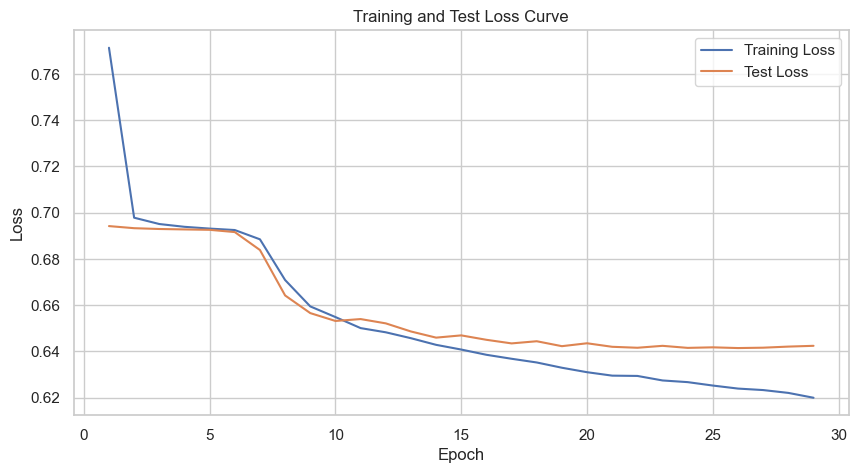

Loss curve saved as loss_curve.png


In [ ]:
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-5
PATIENCE = 3  # Stop if no improvement after 2 epochs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_losses = []
test_losses = []

# Load and modify SqueezeNet
base_model = models.squeezenet1_1(pretrained=True)
base_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 6, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Sigmoid()
)

class SqueezeNetWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        x = self.base_model(x)
        return x.view(x.size(0), -1)

model = SqueezeNetWrapper(base_model).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    model.train()
    running_loss = 0.0
    for images, labels, *_ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels, *_ in small_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    epoch_test_loss = test_loss / len(small_test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model improved and saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            early_stop = True

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

print("Loss curve saved as loss_curve.png")


## VIT

In [7]:
class CreatePatchesLayer(torch.nn.Module):
  """Custom PyTorch Layer to Extract Patches from Images."""

  def __init__(
    self,
    patch_size: int,
    strides: int,
  ) -> None:
    """Init Variables."""
    super().__init__()
    self.unfold_layer = torch.nn.Unfold(
      kernel_size=patch_size, stride=strides
    )

  def forward(self, images: torch.Tensor) -> torch.Tensor:
    """Forward Pass to Create Patches."""
    patched_images = self.unfold_layer(images)
    return patched_images.permute((0, 2, 1))

In [8]:
class PatchEmbeddingLayer(torch.nn.Module):
  """Positional Embedding Layer for Images of Patches."""

  def __init__(
    self,
    num_patches: int,
    #batch_size: int,
    patch_size: int,
    embed_dim: int,
    device: torch.device,
  ) -> None:
    """Init Function."""
    super().__init__()
    self.num_patches = num_patches
    self.patch_size = patch_size
    self.position_emb = torch.nn.Embedding(
      num_embeddings=num_patches + 1, embedding_dim=embed_dim
    )
    self.projection_layer = torch.nn.Linear(
      patch_size * patch_size * 3, embed_dim
    )
    #self.class_parameter = torch.nn.Parameter(      torch.rand(batch_size, 1, embed_dim).to(device),      requires_grad=True,    )
    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    self.device = device

  def forward(self, patches: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""

    batch_size = patches.size(0)
    positions = (
      torch.arange(start=0, end=self.num_patches + 1, step=1)
      .to(self.device)
      .unsqueeze(dim=0)
    )
    patches = self.projection_layer(patches)
    position_embeddings = self.position_emb(positions)
    encoded_patches = torch.cat(
      (self.class_token.expand(batch_size, -1, -1), patches), dim=1
    ) + position_embeddings.expand(batch_size, -1, -1)
    return encoded_patches

In [11]:
def create_mlp_block(
    input_features: int,
    output_features: list[int],
    activation_function: Type[torch.nn.Module],
    dropout_rate: float,
) -> torch.nn.Module:
    """Create a Feed Forward Network for the Transformer Layer."""
    layer_list = []
    for idx in range(  # pylint: disable=consider-using-enumerate
        len(output_features)
    ):
        if idx == 0:
            linear_layer = torch.nn.Linear(
                in_features=input_features, out_features=output_features[idx]
            )
        else:
            linear_layer = torch.nn.Linear(
                in_features=output_features[idx - 1],
                out_features=output_features[idx],
            )
        dropout = torch.nn.Dropout(p=dropout_rate)
        layers = torch.nn.Sequential(
            linear_layer, activation_function(), dropout
        )
        layer_list.append(layers)
    return torch.nn.Sequential(*layer_list)

In [12]:
class TransformerBlock(torch.nn.Module):
  """Transformer Block Layer."""

  def __init__(
    self,
    num_heads: int,
    key_dim: int,
    embed_dim: int,
    ff_dim: int,
    dropout_rate: float = 0.1,
  ) -> None:
    """Init variables and layers."""
    super().__init__()
    self.layer_norm_input = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.attn = torch.nn.MultiheadAttention(
      embed_dim=embed_dim,
      num_heads=num_heads,
      kdim=key_dim,
      vdim=key_dim,
      batch_first=True,
    )

    self.dropout_1 = torch.nn.Dropout(p=dropout_rate)
    self.layer_norm_1 = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.layer_norm_2 = torch.nn.LayerNorm(
      normalized_shape=embed_dim, eps=1e-6
    )
    self.ffn = create_mlp_block(
      input_features=embed_dim,
      output_features=[ff_dim, embed_dim],
      activation_function=torch.nn.GELU,
      dropout_rate=dropout_rate,
    )

  def forward(self, inputs: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""
    layer_norm_inputs = self.layer_norm_input(inputs)
    attention_output, _ = self.attn(
      query=layer_norm_inputs,
      key=layer_norm_inputs,
      value=layer_norm_inputs,
    )
    attention_output = self.dropout_1(attention_output)
    out1 = self.layer_norm_1(inputs + attention_output)
    ffn_output = self.ffn(out1)
    output = self.layer_norm_2(out1 + ffn_output)
    return output

In [13]:
class ViTMultiLabelClassifierModel(torch.nn.Module):
  """ViT Model for Multi-Label Image Classification."""

  def __init__(
      self,
      num_transformer_layers: int,
      embed_dim: int,
      feed_forward_dim: int,
      num_heads: int,
      patch_size: int,
      num_patches: int,
      mlp_head_units: list[int],
      num_classes: int,
      batch_size: int,
      device: torch.device,
  ) -> None:
      """Init Function."""
      super().__init__()
      self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
      self.patch_embedding_layer = PatchEmbeddingLayer(
          num_patches,  patch_size, embed_dim, device
      )
      self.transformer_layers = torch.nn.ModuleList()
      for _ in range(num_transformer_layers):
          self.transformer_layers.append(
              TransformerBlock(
                  num_heads, embed_dim, embed_dim, feed_forward_dim
              )
          )

      self.mlp_block = create_mlp_block(
          input_features=embed_dim,
          output_features=mlp_head_units,
          activation_function=torch.nn.GELU,
          dropout_rate=0.5,
      )

      self.logits_layer = torch.nn.Linear(mlp_head_units[-1], num_classes)
      self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      """Forward Pass."""
      x = self.create_patch_layer(x)
      x = self.patch_embedding_layer(x)
      for transformer_layer in self.transformer_layers:
          x = transformer_layer(x)
      x = x[:, 0]  # CLS token
      x = self.mlp_block(x)
      logits = self.logits_layer(x)
      return self.sigmoid(logits)  # Raw logits for BCEWithLogitsLoss


In [14]:
def train_network(
  model: torch.nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
  trainloader: torch.utils.data.DataLoader,
  validloader: torch.utils.data.DataLoader,
  device: torch.device,
  threshold: float = 0.5,
  patience: int = 5,
  lr_decay_factor: float = 0.1,
  min_lr: float = 1e-6
) -> None:
  """Train the Network (Multi-label) with early stopping and LR decay."""
  print("Training Started")

  best_val_loss = float('inf')
  epochs_no_improve = 0

  # Learning rate scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=lr_decay_factor, patience=2, min_lr=min_lr
  )
  train_losses = []
  val_losses = []
  for epoch in range(1, num_epochs + 1):
    sys.stdout.flush()
    train_loss = []
    valid_loss = []

    all_train_preds, all_train_labels = [], []
    all_valid_preds, all_valid_labels = [], []

    model.train()
    for x, y, *_ in tqdm(trainloader, desc=f"Epoch {epoch} [Train]"):
      x, y = x.to(device), y.float().to(device)
      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_function(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      probs = torch.sigmoid(outputs)
      preds = (probs > threshold).int()
      all_train_preds.append(preds.cpu().numpy())
      all_train_labels.append(y.cpu().numpy())

    model.eval()
    with torch.no_grad():
      for x, y, *_ in tqdm(validloader, desc=f"Epoch {epoch} [Valid]"):
        x, y = x.to(device), y.float().to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
        valid_loss.append(loss.item())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int()
        all_valid_preds.append(preds.cpu().numpy())
        all_valid_labels.append(y.cpu().numpy())

    # Flatten predictions and labels
    y_train_true = np.vstack(all_train_labels)
    y_train_pred = np.vstack(all_train_preds)
    y_valid_true = np.vstack(all_valid_labels)
    y_valid_pred = np.vstack(all_valid_preds)

    # Metrics
    train_acc = accuracy_score(y_train_true, y_train_pred)
    valid_acc = accuracy_score(y_valid_true, y_valid_pred)
    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    valid_f1 = f1_score(y_valid_true, y_valid_pred, average='macro')

    val_loss_mean = np.mean(valid_loss)
    train_loss_mean = np.mean(train_loss)
    train_losses.append(train_loss_mean)
    val_losses.append(val_loss_mean)

    print(
      f"Epoch {epoch}: "
      f"Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss_mean:.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {valid_acc:.4f}, "
      f"Train F1: {train_f1:.4f}, Val F1: {valid_f1:.4f}"
    )

    # Learning rate scheduling
    scheduler.step(val_loss_mean)

    # Early stopping check
    if val_loss_mean < best_val_loss:
      best_val_loss = val_loss_mean
      epochs_no_improve = 0
      best_model_state = model.state_dict()  # Save best model
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        model.load_state_dict(best_model_state)  # Restore best model
        break
  torch.save(model.state_dict(), MODEL_PATH)

  # Plotting
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
  plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Test Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.savefig(LOSS_PATH)
  plt.show()

  print("Loss curve saved as loss_curve.png")


In [15]:
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
IMAGE_SIZE = 128
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]

In [20]:
import pytorch_model_summary as pms
model = ViTMultiLabelClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 2,
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=6,
    batch_size=BATCH_SIZE,
    device=DEVICE,
).to(DEVICE)

pms.summary(
    model,
    torch.rand((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device=DEVICE),
    show_input=False,
    print_summary=True,
    max_depth=5,
    show_parent_layers=True,
)

--------------------------------------------------------------------------------------------------------------------------
                                      Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
    ViTMultiLabelClassifierModel/CreatePatchesLayer           Unfold-1      [32, 108, 441]               0               0
   ViTMultiLabelClassifierModel/PatchEmbeddingLayer           Linear-2       [32, 441, 64]           6,976           6,976
   ViTMultiLabelClassifierModel/PatchEmbeddingLayer        Embedding-3        [1, 442, 64]          28,288          28,288
      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-4       [32, 442, 64]             128             128
      ViTMultiLabelClassifierModel/TransformerBlock          Dropout-5       [32, 442, 64]               0               0
      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-6       [32, 442, 64]             128             128
      ViTMultiLa

'--------------------------------------------------------------------------------------------------------------------------\n                                      Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n    ViTMultiLabelClassifierModel/CreatePatchesLayer           Unfold-1      [32, 108, 441]               0               0\n   ViTMultiLabelClassifierModel/PatchEmbeddingLayer           Linear-2       [32, 441, 64]           6,976           6,976\n   ViTMultiLabelClassifierModel/PatchEmbeddingLayer        Embedding-3        [1, 442, 64]          28,288          28,288\n      ViTMultiLabelClassifierModel/TransformerBlock        LayerNorm-4       [32, 442, 64]             128             128\n      ViTMultiLabelClassifierModel/TransformerBlock          Dropout-5       [32, 442, 64]               0               0\n      V

In [21]:
optimizer = torch.optim.AdamW(
    params=filter(lambda param: param.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
loss_function = torch.nn.BCELoss()

train_network(
    model=model,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=train_loader,
    validloader=small_test_loader,
    device=DEVICE,
)

Training Started


Epoch 1 [Valid]: 100%|██████████| 1000/1000 [00:23<00:00, 42.56it/s]

Epoch 1: Train Loss: 0.6962, Val Loss: 0.6954, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 2 [Valid]: 100%|██████████| 1000/1000 [00:22<00:00, 44.27it/s]

Epoch 2: Train Loss: 0.6961, Val Loss: 0.6960, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 3 [Valid]: 100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s]

Epoch 3: Train Loss: 0.6961, Val Loss: 0.6936, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 4 [Valid]: 100%|██████████| 1000/1000 [00:20<00:00, 48.68it/s]

Epoch 4: Train Loss: 0.6950, Val Loss: 0.6933, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 5 [Valid]: 100%|██████████| 1000/1000 [00:21<00:00, 47.08it/s]

Epoch 5: Train Loss: 0.6948, Val Loss: 0.6935, Train Acc: 0.0759, Val Acc: 0.0800, Train F1: 0.6673, Val F1: 0.6635



Epoch 6 [Train]:  20%|█▉        | 32/161 [00:51<03:26,  1.60s/it]


KeyboardInterrupt: 